In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from value import Value

In [11]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # create a node
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # create an op node
            dot.node(name=uid + n._op, label=n._op)
            # connect the op node to the value node
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

In [16]:
a=Value(-4.0, label='a')
b=Value(2.0, label='b')
c=a+b; c.label='c'
d=Value(3.0); d.label='d'
e=c*d; e.label='e'

In [18]:
e.backward()

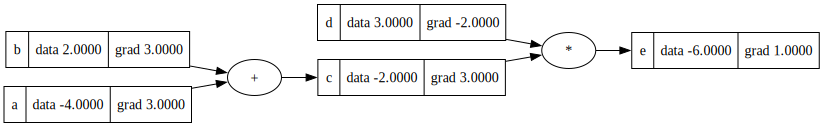

In [19]:
draw_dot(e)

In [4]:
e.backward()